Get File

In [0]:
import pandas as pd

In [4]:
from google.colab import files
uploaded = files.upload()

Saving amazon_alexa.tsv to amazon_alexa.tsv


Look at data

In [0]:
df=pd.read_csv('amazon_alexa.tsv',delimiter='\t',encoding='utf-8')

In [10]:
df.shape

(3150, 5)

In [6]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [8]:
df.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [17]:
list(df.date)
finish_date = min(df.date)
print("Finish Date: " + finish_date)
start_date = max(df.date)
print("Start Date: " + start_date)

Finish Date: 1-Jul-18
Start Date: 9-Jun-18


Remove Reviews that are Blank

In [0]:
df=df[df.verified_reviews != " "]

In [36]:
df.shape

(3071, 5)

In [115]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,love my echo,1
1,5,31-Jul-18,Charcoal Fabric,loved it,1
2,4,31-Jul-18,Walnut Finish,sometimes while playing a game you can answer ...,1
3,5,31-Jul-18,Charcoal Fabric,i have had a lot of fun with this thing my yr...,1
4,5,31-Jul-18,Charcoal Fabric,music,1


In [0]:
import seaborn as sns

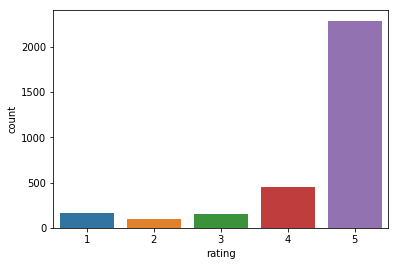

In [19]:
sns.countplot(x='rating', data=df)

In [0]:
import matplotlib.pyplot as plt

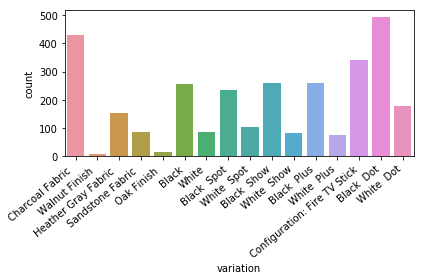

In [41]:
variation_graph = sns.countplot(x="variation", data=df)

variation_graph.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

Data Preparation

In [47]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import pickle
import sys
import os
import io
import re
from sys import path
import numpy as np
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from string import punctuation, digits
from IPython.core.display import display, HTML
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer


Remove Stop words preparaiton
```
# This is formatted as code
```



In [0]:
#Text Preprocessing
columns = ['variation','rating', 'verified_reviews']
df_ = pd.DataFrame(columns=columns)
df1=df
#lower string
df1['verified_reviews'] = df1['verified_reviews'].str.lower()
#remove email adress
df1['verified_reviews'] = df1['verified_reviews'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)
#remove IP address
df1['verified_reviews'] = df1['verified_reviews'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)
#remove punctaitions and special chracters
df1['verified_reviews'] = df1['verified_reviews'].str.replace('[^\w\s]','')
#remove numbers
df1['verified_reviews'] = df1['verified_reviews'].replace('\d', '', regex=True)
#remove stop words
for index, row in df1.iterrows():
    word_tokens = word_tokenize(row['verified_reviews'])
    filtered_sentence = [w for w in word_tokens if not w in stopwords.words('english')]
    df_ = df_.append({"variation": row['variation'],"feedback": row['feedback'], "rating":  row['rating'],"verified_reviews": " ".join(filtered_sentence[0:])}, ignore_index=True)
data = df_

In [62]:
data.head()

,variation,rating,verified_reviews
0,Charcoal Fabric,5,love echo
1,Charcoal Fabric,5,loved
2,Walnut Finish,4,sometimes playing game answer question correct...
3,Charcoal Fabric,5,lot fun thing yr old learns dinosaurs control ...
4,Charcoal Fabric,5,music


In [0]:
data['words'] = data.verified_reviews.str.strip().str.split('[\W_]+')

In [65]:
data.head()

,variation,rating,verified_reviews,words
0,Charcoal Fabric,5,love echo,"[love, echo]"
1,Charcoal Fabric,5,loved,[loved]
2,Walnut Finish,4,sometimes playing game answer question correct...,"[sometimes, playing, game, answer, question, c..."
3,Charcoal Fabric,5,lot fun thing yr old learns dinosaurs control ...,"[lot, fun, thing, yr, old, learns, dinosaurs, ..."
4,Charcoal Fabric,5,music,[music]


In [0]:

X_train, X_test, y_train, y_test = train_test_split(data['verified_reviews'].values.astype('U'),data['rating'].values.astype('int32'), test_size=0.30, random_state=145)
classes  = data['rating'].unique()

In [68]:
rows = list()
for row in data[['rating', 'words']].iterrows():
    r = row[1]
    for word in r.words:
        rows.append((r.rating, word))

words = pd.DataFrame(rows, columns=['rating', 'word'])
words.head()

,rating,word
0,5,love
1,5,echo
2,5,loved
3,4,sometimes
4,4,playing


In [69]:
words = words[words.word.str.len() > 0]
words.head()

,rating,word
0,5,love
1,5,echo
2,5,loved
3,4,sometimes
4,4,playing


In [70]:
counts = words.groupby('rating')\
    .word.value_counts()\
    .to_frame()\
    .rename(columns={'word':'n_w'})
counts.head()

n_w
rating word       
1      echo     49
       amazon   43
       would    31
       one      29
       dot      26

n_w
rating word        
1      echo      49
       amazon    43
       would     31
       one       29
       dot       26
2      echo      41
       alexa     35
       device    29
       like      27
       music     24
3      echo      53
       alexa     51
       like      36
       speaker   30
       dot       28
4      echo     150
       great    124
       like     117
       alexa    116
       music    100
5      love     845
       great    561
       echo     533
       alexa    392
       music    366

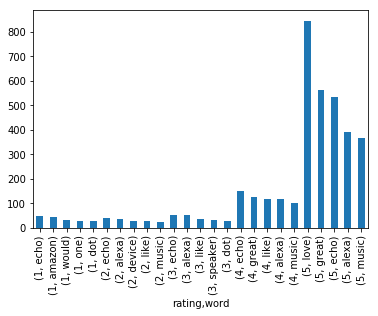

In [71]:
def pretty_plot_top_n(series, top_n=5, index_level=0):
    r = series\
    .groupby(level=index_level)\
    .nlargest(top_n)\
    .reset_index(level=index_level, drop=True)
    r.plot.bar()
    return r.to_frame()


pretty_plot_top_n(counts['n_w'])

Remove words to find better insights on root causes of rating

In [0]:
words=words[words.word != "echo"]
words=words[words.word != "amazon"]
words=words[words.word != "alexa"]
words=words[words.word != "dot"]
words=words[words.word != "would"]
words=words[words.word != "use"]
words=words[words.word != "product"]
words=words[words.word != "device"]
words=words[words.word != "get"]
words=words[words.word != "bought"]
words=words[words.word != "love"]
words=words[words.word != "like"]
words=words[words.word != "great"]
words=words[words.word != "good"]
words=words[words.word != "even"]
words=words[words.word != "set"]
words=words[words.word != "im"]
words=words[words.word != "still"]

In [0]:
words.head()

In [103]:
counts1 = words.groupby('rating')\
    .word.value_counts()\
    .to_frame()\
    .rename(columns={'word':'n_w'})
counts1.head()

n_w
rating word       
1      one      29
       work     24
       time     19
       doesnt   18
       screen   18

n_w
rating word        
1      one       29
       work      24
       time      19
       doesnt    18
       screen    18
2      music     24
       play      22
       sound     21
       work      19
       dont      17
3      speaker   30
       music     28
       sound     27
       doesnt    26
       quality   26
4      music    100
       sound     68
       speaker   66
       works     62
       one       51
5      music    366
       easy     289
       works    277
       one      238
       sound    211

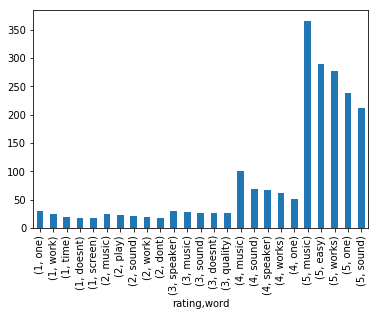

In [104]:
def pretty_plot_top_n(series, top_n=5, index_level=0):
    r = series\
    .groupby(level=index_level)\
    .nlargest(top_n)\
    .reset_index(level=index_level, drop=True)
    r.plot.bar()
    return r.to_frame()


pretty_plot_top_n(counts1['n_w'])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df1['verified_reviews'].values.astype('U'),data['rating'].values.astype('int32'), test_size=0.30, random_state=145)
classes  = data['feedback'].unique()

Naive Bayes

In [0]:
df2=data
df2['verified_reviews'] = data['verified_reviews'].apply(lambda x: ' '.join(x))
count_vect = CountVectorizer()
counts = count_vect.fit_transform(df['verified_reviews'])
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer().fit(counts)

counts = transformer.transform(counts)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(counts, df['rating'], test_size=0.1, random_state=69)
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB().fit(X_train, y_train)

In [151]:
import numpy as np

predicted = model.predict(X_test)

print(np.mean(predicted == y_test))

0.7714285714285715


SVM

In [138]:
trainData=np.column_stack((X_train, y_train))
trainData=pd.DataFrame(trainData)
testData=np.column_stack((X_test, y_test))
testData=pd.DataFrame(testData)
testData.head()

,0,1
0,love alexa these are the best thing i have eve...,5
1,best thing ive invested in in a while thank yo...,5
2,works great bought it for my shop so that it i...,5
3,love my echo,5
4,loved it till someone stoled it cant afford to...,5


In [0]:
testData.columns = ['verified_reviews', 'rating']
trainData.columns = ['verified_reviews', 'rating']

In [140]:
for col in testData.columns: 
    print(col)

verified_reviews
rating


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
train_vectors = vectorizer.fit_transform(trainData['verified_reviews'])
test_vectors = vectorizer.transform(testData['verified_reviews'])

In [142]:
import time
from sklearn import svm
from sklearn.metrics import classification_report
# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
t0 = time.time()
classifier_linear.fit(train_vectors, trainData['rating'])
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(testData['rating'], prediction_linear, output_dict=True)
print('one ', report['1'])
print('two: ', report['2'])
print('three: ', report['3'])
print('four: ', report['4'])
print('five: ', report['5'])


Training time: 0.705191s; Prediction time: 0.195688s
one  {'precision': 0.7391304347826086, 'recall': 0.288135593220339, 'f1-score': 0.41463414634146345, 'support': 59}
two:  {'precision': 1.0, 'recall': 0.15384615384615385, 'f1-score': 0.2666666666666667, 'support': 26}
three:  {'precision': 0.6363636363636364, 'recall': 0.17073170731707318, 'f1-score': 0.2692307692307692, 'support': 41}
four:  {'precision': 0.46296296296296297, 'recall': 0.1773049645390071, 'f1-score': 0.25641025641025644, 'support': 141}
five:  {'precision': 0.7784290738569754, 'recall': 0.9793510324483776, 'f1-score': 0.8674069235793599, 'support': 678}
